# 1. Setup and Environment

Install PyTorch GPU

In [1]:
!pip install torch==2.5.1 torchvision==0.20.1 torchaudio==2.5.1 --index-url https://download.pytorch.org/whl/cu124

Looking in indexes: https://download.pytorch.org/whl/cu124


In [2]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import random

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'  # Set CUDA_LAUNCH_BLOCKING=1

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# 2. Data Loading and Preparation

We’ll use the MovieLens 100K dataset, which contains 100,000 movie ratings from users

In [3]:
!curl -O -L https://files.grouplens.org/datasets/movielens/ml-100k.zip
!powershell -Command "Expand-Archive -Path 'ml-100k.zip' -DestinationPath '.' -Force"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0 4808k    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  9 4808k    9  464k    0     0   246k      0  0:00:19  0:00:01  0:00:18  246k
100 4808k  100 4808k    0     0  1911k      0  0:00:02  0:00:02 --:--:-- 1914k
. : File C:\Users\goldi\Documents\WindowsPowerShell\profile.ps1 cannot be loaded because running scripts is disabled 
on this system. For more information, see about_Execution_Policies at https:/go.microsoft.com/fwlink/?LinkID=135170.
At line:1 char:3
+ . 'C:\Users\goldi\Documents\WindowsPowerShell\profile.ps1'
+   ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    + CategoryInfo          : SecurityError: (:) [], PSSecurityException
    + FullyQualifiedErrorId : UnauthorizedAccess


Load user's rating data

In [4]:
ratings_df = pd.read_csv('ml-100k/u.data', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])

In [5]:
print("Ratings data:")
print(ratings_df.head())

Ratings data:
   user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596


Load movie data

In [6]:
movies_df = pd.read_csv('ml-100k/u.item', sep='|', encoding='latin-1',
                       names=['item_id', 'title', 'release_date', 'video_release_date',
                              'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation',
                              'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
                              'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
                              'Thriller', 'War', 'Western'])

In [7]:
print("nMovies data:")
print(movies_df[['item_id', 'title']].head())

nMovies data:
   item_id              title
0        1   Toy Story (1995)
1        2   GoldenEye (1995)
2        3  Four Rooms (1995)
3        4  Get Shorty (1995)
4        5     Copycat (1995)


Check number of data

In [8]:
print(f"nTotal number of ratings: {len(ratings_df)}")
print(f"Number of unique users: {ratings_df['user_id'].nunique()}")
print(f"Number of unique movies: {ratings_df['item_id'].nunique()}")
print(f"Rating range: {ratings_df['rating'].min()} to {ratings_df['rating'].max()}")
print(f"Average rating: {ratings_df['rating'].mean():.2f}")

nTotal number of ratings: 100000
Number of unique users: 943
Number of unique movies: 1682
Rating range: 1 to 5
Average rating: 3.53


Check distribution of ratings

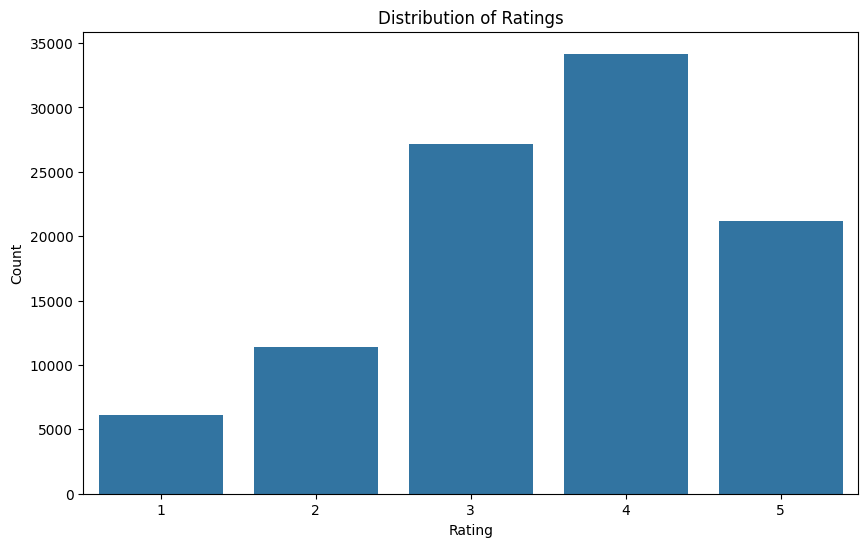

In [9]:
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=ratings_df)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# 3. Data Preparation for NCF

In [10]:
train_df, test_df = train_test_split(ratings_df, test_size=0.2, random_state=42)


print(f"Training set size: {len(train_df)}")
print(f"Test set size: {len(test_df)}")

Training set size: 80000
Test set size: 20000


In [11]:
num_users = ratings_df['user_id'].max()
num_items = ratings_df['item_id'].max()


print(f"Number of users: {num_users}")
print(f"Number of items: {num_items}")

Number of users: 943
Number of items: 1682


In [12]:
class NCFDataset(Dataset):
   def __init__(self, df):
       self.user_ids = torch.tensor(df['user_id'].values, dtype=torch.long)
       self.item_ids = torch.tensor(df['item_id'].values, dtype=torch.long)
       self.labels = torch.tensor(df['rating'].values, dtype=torch.float)
      
   def __len__(self):
       return len(self.user_ids)
  
   def __getitem__(self, idx):
       return {
           'user_id': self.user_ids[idx],
           'item_id': self.item_ids[idx],
           'label': self.labels[idx]
       }


train_dataset = NCFDataset(train_df)
test_dataset = NCFDataset(test_df)


batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 4. Model Architecture

In [13]:
class NCF(nn.Module):
   def __init__(self, num_users, num_items, embedding_dim=32, mlp_layers=[64, 32, 16]):
       super(NCF, self).__init__() 

       self.user_embedding_gmf = nn.Embedding(num_users + 1, embedding_dim)
       self.item_embedding_gmf = nn.Embedding(num_items + 1, embedding_dim)

       self.user_embedding_mlp = nn.Embedding(num_users + 1, embedding_dim)
       self.item_embedding_mlp = nn.Embedding(num_items + 1, embedding_dim)
      
       mlp_input_dim = 2 * embedding_dim
       self.mlp_layers = nn.ModuleList()
       for idx, layer_size in enumerate(mlp_layers):
           if idx == 0:
               self.mlp_layers.append(nn.Linear(mlp_input_dim, layer_size))
           else:
               self.mlp_layers.append(nn.Linear(mlp_layers[idx-1], layer_size))
           self.mlp_layers.append(nn.ReLU())

       self.output_layer = nn.Linear(embedding_dim + mlp_layers[-1], 1)
       self.sigmoid = nn.Sigmoid()

       self._init_weights()
  
   def _init_weights(self):
       for m in self.modules():
           if isinstance(m, nn.Embedding):
               nn.init.normal_(m.weight, mean=0.0, std=0.01)
           elif isinstance(m, nn.Linear):
               nn.init.kaiming_uniform_(m.weight)
               if m.bias is not None:
                   nn.init.zeros_(m.bias)
  
   def forward(self, user_ids, item_ids):
       user_embedding_gmf = self.user_embedding_gmf(user_ids)
       item_embedding_gmf = self.item_embedding_gmf(item_ids)
       gmf_vector = user_embedding_gmf * item_embedding_gmf
      
       user_embedding_mlp = self.user_embedding_mlp(user_ids)
       item_embedding_mlp = self.item_embedding_mlp(item_ids)
       mlp_vector = torch.cat([user_embedding_mlp, item_embedding_mlp], dim=-1)

       for layer in self.mlp_layers:
           mlp_vector = layer(mlp_vector)

       concat_vector = torch.cat([gmf_vector, mlp_vector], dim=-1)

       prediction = self.sigmoid(self.output_layer(concat_vector)).squeeze()

       return prediction


embedding_dim = 32
mlp_layers = [64, 32, 16]
model = NCF(num_users, num_items, embedding_dim, mlp_layers).to(device)

print(model)

NCF(
  (user_embedding_gmf): Embedding(944, 32)
  (item_embedding_gmf): Embedding(1683, 32)
  (user_embedding_mlp): Embedding(944, 32)
  (item_embedding_mlp): Embedding(1683, 32)
  (mlp_layers): ModuleList(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): ReLU()
  )
  (output_layer): Linear(in_features=48, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


# 5.Training the Model

In [14]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)


def train_epoch(model, data_loader, criterion, optimizer, device):
   model.train()
   total_loss = 0
   for batch in tqdm(data_loader, desc="Training"):
       user_ids = batch['user_id'].to(device)
       item_ids = batch['item_id'].to(device)
       labels = batch['label'].to(device)
      
       optimizer.zero_grad()
       outputs = model(user_ids, item_ids)
       loss = criterion(outputs, labels)
      
       loss.backward()
       optimizer.step()
      
       total_loss += loss.item()
  
   return total_loss / len(data_loader)


def evaluate(model, data_loader, criterion, device):
   model.eval()
   total_loss = 0
   predictions = []
   true_labels = []
  
   with torch.no_grad():
       for batch in tqdm(data_loader, desc="Evaluating"):
           user_ids = batch['user_id'].to(device)
           item_ids = batch['item_id'].to(device)
           labels = batch['label'].to(device)
          
           outputs = model(user_ids, item_ids)
           loss = criterion(outputs, labels)
           total_loss += loss.item()
          
           predictions.extend(outputs.cpu().numpy())
           true_labels.extend(labels.cpu().numpy())
  
   from sklearn.metrics import roc_auc_score, average_precision_score
   auc = roc_auc_score(true_labels, predictions)
   ap = average_precision_score(true_labels, predictions)
  
   return {
       'loss': total_loss / len(data_loader),
       'auc': auc,
       'ap': ap
   }


num_epochs = 10
history = {'train_loss': [], 'val_loss': [], 'val_auc': [], 'val_ap': []}


for epoch in range(num_epochs):
   train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
  
   eval_metrics = evaluate(model, test_loader, criterion, device)
  
   history['train_loss'].append(train_loss)
   history['val_loss'].append(eval_metrics['loss'])
   history['val_auc'].append(eval_metrics['auc'])
   history['val_ap'].append(eval_metrics['ap'])
  
   print(f"Epoch {epoch+1}/{num_epochs} - "
         f"Train Loss: {train_loss:.4f}, "
         f"Val Loss: {eval_metrics['loss']:.4f}, "
         f"AUC: {eval_metrics['auc']:.4f}, "
         f"AP: {eval_metrics['ap']:.4f}")


plt.figure(figsize=(12, 4))


plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history['val_auc'], label='AUC')
plt.plot(history['val_ap'], label='Average Precision')
plt.title('Evaluation Metrics')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()


plt.tight_layout()
plt.show()


torch.save(model.state_dict(), 'ncf_model.pth')
print("Model saved successfully!")

Training:   0%|          | 0/313 [00:01<?, ?it/s]


RuntimeError: CUDA error: device-side assert triggered
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


# 6. Generating Recommendations

In [ ]:
def generate_recommendations(model, user_id, n=10):
   model.eval()
   user_ids = torch.tensor([user_id] * num_items, dtype=torch.long).to(device)
   item_ids = torch.tensor(range(1, num_items + 1), dtype=torch.long).to(device)
  
   with torch.no_grad():
       predictions = model(user_ids, item_ids).cpu().numpy()
  
   items_df = pd.DataFrame({
       'item_id': range(1, num_items + 1),
       'score': predictions
   })
  
   user_rated_items = set(ratings_df[ratings_df['user_id'] == user_id]['item_id'].values)
  
   items_df = items_df[~items_df['item_id'].isin(user_rated_items)]
  
   top_n_items = items_df.sort_values('score', ascending=False).head(n)
  
   recommendations = pd.merge(top_n_items, movies_df[['item_id', 'title']], on='item_id')
  
   return recommendations[['item_id', 'title', 'score']]


test_users = [1, 42, 100]


for user_id in test_users:
   print(f"nTop 10 recommendations for user {user_id}:")
   recommendations = generate_recommendations(model, user_id, n=10)
   print(recommendations)
  
   print(f"nMovies that user {user_id} has rated highly (4-5 stars):")
   user_liked = ratings_df[(ratings_df['user_id'] == user_id) & (ratings_df['rating'] >= 4)]
   user_liked = pd.merge(user_liked, movies_df[['item_id', 'title']], on='item_id')
   user_liked[['item_id', 'title', 'rating']]

# 7. Evaluating the Model Further

In [ ]:
def evaluate_model_with_metrics(model, test_loader, device):
   model.eval()
   predictions = []
   true_labels = []
  
   with torch.no_grad():
       for batch in tqdm(test_loader, desc="Evaluating"):
           user_ids = batch['user_id'].to(device)
           item_ids = batch['item_id'].to(device)
           labels = batch['label'].to(device)
          
           outputs = model(user_ids, item_ids)
          
           predictions.extend(outputs.cpu().numpy())
           true_labels.extend(labels.cpu().numpy())
  
   from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, accuracy_score
  
   binary_preds = [1 if p >= 0.5 else 0 for p in predictions]
  
   auc = roc_auc_score(true_labels, predictions)
   ap = average_precision_score(true_labels, predictions)
   accuracy = accuracy_score(true_labels, binary_preds)
  
   precision, recall, thresholds = precision_recall_curve(true_labels, predictions)
  
   plt.figure(figsize=(10, 6))
   plt.plot(recall, precision, label=f'AP={ap:.3f}')
   plt.xlabel('Recall')
   plt.ylabel('Precision')
   plt.title('Precision-Recall Curve')
   plt.legend()
   plt.grid(True)
   plt.show()
  
   return {
       'auc': auc,
       'ap': ap,
       'accuracy': accuracy
   }


metrics = evaluate_model_with_metrics(model, test_loader, device)
print(f"AUC: {metrics['auc']:.4f}")
print(f"Average Precision: {metrics['ap']:.4f}")
print(f"Accuracy: {metrics['accuracy']:.4f}")

# 8. Cold Start Analysis

In [ ]:
user_rating_counts = ratings_df.groupby('user_id').size().reset_index(name='count')
user_rating_counts['group'] = pd.cut(user_rating_counts['count'],
                                   bins=[0, 10, 50, 100, float('inf')],
                                   labels=['1-10', '11-50', '51-100', '100+'])


print("Number of users in each rating frequency group:")
print(user_rating_counts['group'].value_counts())


def evaluate_by_user_group(model, ratings_df, user_groups, device):
   results = {}
  
   for group_name, user_ids in user_groups.items():
       group_ratings = ratings_df[ratings_df['user_id'].isin(user_ids)]
      
       group_dataset = NCFDataset(group_ratings)
       group_loader = DataLoader(group_dataset, batch_size=256, shuffle=False)
      
       if len(group_loader) == 0:
           continue
      
       model.eval()
       predictions = []
       true_labels = []
      
       with torch.no_grad():
           for batch in group_loader:
               user_ids = batch['user_id'].to(device)
               item_ids = batch['item_id'].to(device)
               labels = batch['label'].to(device)
              
               outputs = model(user_ids, item_ids)
              
               predictions.extend(outputs.cpu().numpy())
               true_labels.extend(labels.cpu().numpy())
      
       from sklearn.metrics import roc_auc_score
       try:
           auc = roc_auc_score(true_labels, predictions)
           results[group_name] = auc
       except:
           results[group_name] = None
  
   return results


user_groups = {}
for group in user_rating_counts['group'].unique():
   users_in_group = user_rating_counts[user_rating_counts['group'] == group]['user_id'].values
   user_groups[group] = users_in_group


group_performance = evaluate_by_user_group(model, test_df, user_groups, device)


plt.figure(figsize=(10, 6))
groups = []
aucs = []


for group, auc in group_performance.items():
   if auc is not None:
       groups.append(group)
       aucs.append(auc)


plt.bar(groups, aucs)
plt.xlabel('Number of Ratings per User')
plt.ylabel('AUC Score')
plt.title('Model Performance by User Rating Frequency (Cold Start Analysis)')
plt.ylim(0.5, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


print("AUC scores by user rating frequency:")
for group, auc in group_performance.items():
   if auc is not None:
       print(f"{group}: {auc:.4f}")

# 9. Business Insights and Extensions

In [ ]:
def analyze_predictions(model, data_loader, device):
   model.eval()
   predictions = []
   true_labels = []
  
   with torch.no_grad():
       for batch in data_loader:
           user_ids = batch['user_id'].to(device)
           item_ids = batch['item_id'].to(device)
           labels = batch['label'].to(device)
          
           outputs = model(user_ids, item_ids)
          
           predictions.extend(outputs.cpu().numpy())
           true_labels.extend(labels.cpu().numpy())
  
   results_df = pd.DataFrame({
       'true_label': true_labels,
       'predicted_score': predictions
   })
  
   plt.figure(figsize=(12, 6))
  
   plt.subplot(1, 2, 1)
   sns.histplot(results_df['predicted_score'], bins=30, kde=True)
   plt.title('Distribution of Predicted Scores')
   plt.xlabel('Predicted Score')
   plt.ylabel('Count')
  
   plt.subplot(1, 2, 2)
   sns.boxplot(x='true_label', y='predicted_score', data=results_df)
   plt.title('Predicted Scores by True Label')
   plt.xlabel('True Label (0=Disliked, 1=Liked)')
   plt.ylabel('Predicted Score')
  
   plt.tight_layout()
   plt.show()
  
   avg_scores = results_df.groupby('true_label')['predicted_score'].mean()
   print("Average prediction scores:")
   print(f"Items user disliked (0): {avg_scores[0]:.4f}")
   print(f"Items user liked (1): {avg_scores[1]:.4f}")


analyze_predictions(model, test_loader, device)